In [70]:
import pandas as pd  
import numpy as np  
import os
from fbprophet import Prophet
import seaborn as sns
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [2]:
class suppress_stdout_stderr(object):
    def __init__(self):
        self.null_fds = [os.open(os.devnull, os.O_RDWR) for x in range(2)]
        self.save_fds = [os.dup(1), os.dup(2)]

    def __enter__(self):
        os.dup2(self.null_fds[0], 1)
        os.dup2(self.null_fds[1], 2)

    def __exit__(self, *_):
        os.dup2(self.save_fds[0], 1)
        os.dup2(self.save_fds[1], 2)
        for fd in self.null_fds + self.save_fds:
            os.close(fd)

with suppress_stdout_stderr(): 
    from fbprophet import Prophet

In [122]:
df = pd.read_csv('Zip_Zhvi_SingleFamilyResidence.csv')

# EDA

In [123]:
Prices = df.loc[:,'1996-01-31':'2020-03-31']
Prices = Prices.assign(City=df.City)

In [124]:
Prices = Prices.assign(Metro=df.Metro)
Prices = Prices.assign(State=df.State)

In [125]:
Prices

,1996-01-31,1996-02-29,1996-03-31,1996-04-30,1996-05-31,1996-06-30,1996-07-31,1996-08-31,1996-09-30,1996-10-31,...,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,City,Metro,State
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1390420.0,1381621.0,1375725.0,1374714.0,1381453.0,1385737.0,1389268.0,New York,New York-Newark-Jersey City,NY
1,364892.0,364162.0,363605.0,362963.0,361660.0,361342.0,360662.0,361804.0,363561.0,366592.0,...,975251.0,974238.0,973104.0,971908.0,972038.0,973671.0,975642.0,Chicago,Chicago-Naperville-Elgin,IL
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1492429.0,1486122.0,1480426.0,1476509.0,1478980.0,1479301.0,1474994.0,New York,New York-Newark-Jersey City,NY
3,200475.0,200723.0,200526.0,199337.0,198200.0,197534.0,198298.0,197986.0,197333.0,196543.0,...,336092.0,336119.0,336083.0,336154.0,335860.0,336037.0,336483.0,Katy,Houston-The Woodlands-Sugar Land,TX
4,546663.0,546231.0,545451.0,545391.0,543066.0,543084.0,542380.0,545254.0,548142.0,552660.0,...,1206304.0,1204013.0,1201182.0,1198879.0,1198277.0,1199900.0,1200980.0,Chicago,Chicago-Naperville-Elgin,IL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30459,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,130602.0,130836.0,130717.0,130725.0,130869.0,131717.0,132127.0,Charlotte Amalie,NaN,UT
30460,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,101516.0,101698.0,101363.0,100458.0,100233.0,100404.0,100708.0,Choudrant,Ruston,LA
30461,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,173377.0,174192.0,175176.0,175615.0,176689.0,178685.0,181195.0,Choudrant,Ruston,LA
30462,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,73647.0,73961.0,74273.0,74583.0,74891.0,75145.0,75464.0,Logan,Cullman,AL


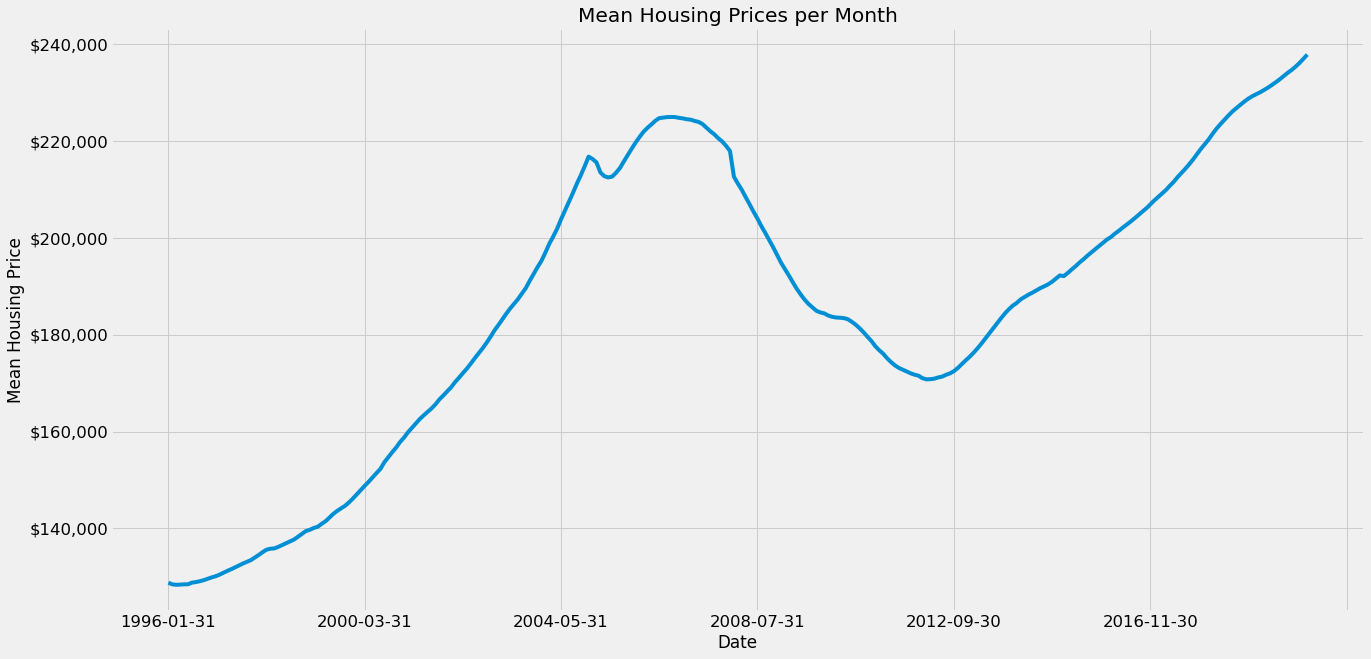

In [126]:
city_mean = Prices.mean()
plt.figure(figsize=(20, 10))
city_mean.plot()
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
plt.gca().yaxis.set_major_formatter(tick) 
plt.title('Mean Housing Prices per Month')
plt.ylabel('Mean Housing Price')
plt.xlabel('Date')
plt.show()

In [127]:
columns = ['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName', 'SizeRank']
Prices = df.iloc[:, 9:]

data = pd.pivot_table(df, values=Prices, columns=columns)
data = data.reset_index()
data.rename(columns={'level_0':'date', 0:'value'}, inplace=True)
data['date'] = pd.to_datetime(data['date'], infer_datetime_format=True)

data

,date,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value
0,1996-01-31,58001,501,Holtsville,NY,New York-Newark-Jersey City,Suffolk County,34430,NaN
1,1996-01-31,58004,602,Auburn,AL,Auburn-Opelika,Lee County,4818,NaN
2,1996-01-31,58006,604,Aguadilla,AL,Dothan,Houston County,20734,NaN
3,1996-01-31,58007,605,Aguadilla,AL,Dothan,Houston County,12420,NaN
4,1996-01-31,58008,606,Neosho,MO,Joplin,Newton County,15069,NaN
...,...,...,...,...,...,...,...,...,...
6786115,2020-03-31,698721,86005,Flagstaff,AZ,Flagstaff,Coconino County,6485,433394.0
6786116,2020-03-31,738092,97003,Beaverton,OR,Portland-Vancouver-Hillsboro,Washington County,4398,373171.0
6786117,2020-03-31,738094,73960,Texhoma,OK,Guymon,Texas County,31781,57676.0
6786118,2020-03-31,753843,97703,Bend,OR,Bend-Redmond,Deschutes County,2850,666072.0


# AR Analysis

In [188]:
AR = data[data['State'] == 'AR']

<Figure size 1440x720 with 0 Axes>

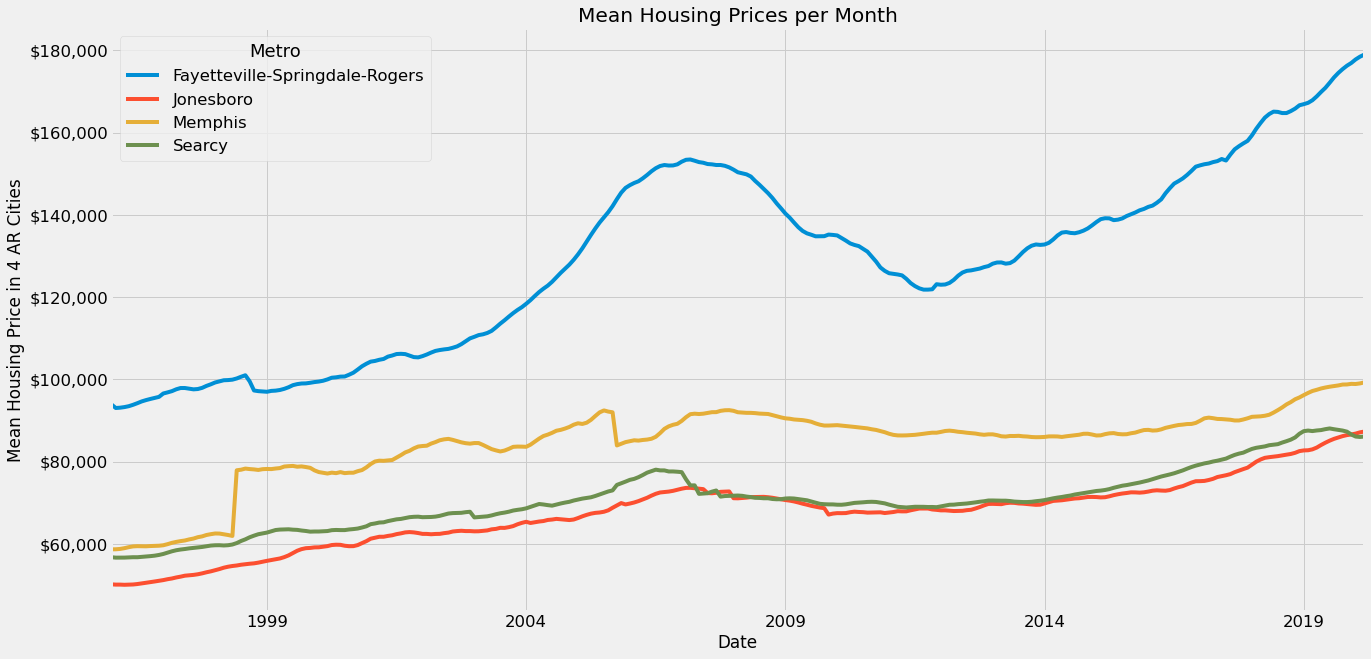

In [190]:
AR_Cities = AR[(AR['Metro']=='Jonesboro') |
                          (AR['Metro']=='Fayetteville-Springdale-Rogers') |
                          (AR['Metro']=='Searcy') |
                          (AR['Metro']=='Memphis')]
AR_Cities_Mean = AR_Cities.groupby(['date', 'Metro'])['value'].mean()
AR_Cities_Mean = AR_Cities_Mean.reset_index()
AR_Cities_Mean_Plot = AR_Cities_Mean.pivot(index='date', columns='Metro', values='value')

plt.figure(figsize=(20, 10))
AR_Cities_Mean_Plot.plot(figsize=(20, 10))
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
plt.gca().yaxis.set_major_formatter(tick) 
plt.title('Mean Housing Prices per Month')
plt.ylabel('Mean Housing Price in 4 AR Cities')
plt.xlabel('Date')
plt.show()

In [141]:
Metro = data.groupby(['date', 'Metro'])['value'].mean()
Metro = Metro.reset_index()
Metro.columns = ['date', 'Metro', 'avg_value']
Metro = Metro.rename(columns={ "date": "ds","avg_value": "y" })
Metro

,ds,Metro,y
0,1996-01-31,Aberdeen,NaN
1,1996-01-31,Abilene,NaN
2,1996-01-31,Ada,33940.400000
3,1996-01-31,Adrian,78817.400000
4,1996-01-31,Akron,110765.047619
...,...,...,...
250546,2020-03-31,Youngstown-Warren-Boardman,113832.030769
250547,2020-03-31,Yuba City,350552.923077
250548,2020-03-31,Yuma,143467.800000
250549,2020-03-31,Zanesville,116138.647059


In [155]:
Fayetteville = Metro[Metro.Metro == 'Fayetteville']
Fayetteville 

,ds,Metro,y
261,1996-01-31,Fayetteville,97097.000000
1122,1996-02-29,Fayetteville,97338.923077
1983,1996-03-31,Fayetteville,97474.000000
2844,1996-04-30,Fayetteville,97791.230769
3705,1996-05-31,Fayetteville,97905.076923
...,...,...,...
246507,2019-11-30,Fayetteville,139208.687500
247368,2019-12-31,Fayetteville,139931.437500
248229,2020-01-31,Fayetteville,140591.125000
249090,2020-02-29,Fayetteville,140992.875000


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


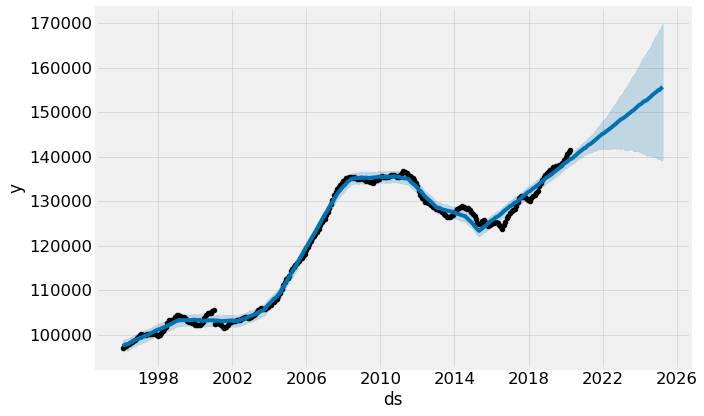

In [156]:
m = Prophet()
m.fit(Fayetteville)
future = m.make_future_dataframe(periods=60, freq='M')
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
fig1 = m.plot(forecast)

In [157]:
forecast = forecast.drop(columns=['ds'])
test = forecast.T
test['total_growth'] = (test[350]-test[290])
test['perc_growth'] = (test[350]-test[290])/test[290]
test

,0,1,2,3,4,5,6,7,8,9,...,343,344,345,346,347,348,349,350,total_growth,perc_growth
trend,97481.243043,97632.765903,97794.738615,97951.486401,98113.459113,98270.206899,98432.179611,98594.152323,98750.900109,98912.872821,...,153747.196080,154014.273568,154290.253639,154557.331127,154833.311198,155109.291269,155358.563591,155634.543661,16256.116431,0.116633
yhat_lower,96159.866626,96388.039817,96654.584184,96413.956871,96585.840728,96968.187952,97062.069371,97316.537275,97437.001195,97635.449262,...,140188.596928,139832.483019,139968.055500,139706.618661,139383.688884,139582.315814,139077.464437,139353.856610,1261.821678,0.009138
yhat_upper,98812.671655,98934.623041,99064.174920,99232.930693,99297.553118,99602.856810,99626.450447,99847.910409,100042.997457,100238.292172,...,165593.626057,166116.887213,166990.118848,167186.120230,168088.998200,168536.964114,169252.221501,169914.861662,29231.112734,0.207779
trend_lower,97481.243043,97632.765903,97794.738615,97951.486401,98113.459113,98270.206899,98432.179611,98594.152323,98750.900109,98912.872821,...,140110.941376,139951.109954,139951.626554,139845.113745,139921.852670,139756.158929,139613.405939,139260.816788,-117.610443,-0.000844
trend_upper,97481.243043,97632.765903,97794.738615,97951.486401,98113.459113,98270.206899,98432.179611,98594.152323,98750.900109,98912.872821,...,165276.211679,165879.285656,166570.358714,167210.707170,167911.539377,168579.209264,169133.150428,169902.030631,30523.603401,0.218998
additive_terms,-0.704215,46.860949,73.444764,-104.492790,-140.231870,-77.479659,-80.475310,33.022944,20.229853,39.008475,...,33.022944,20.229853,39.008475,22.640870,85.820972,-134.053326,17.146664,18.018596,-55.426168,-0.754665
additive_terms_lower,-0.704215,46.860949,73.444764,-104.492790,-140.231870,-77.479659,-80.475310,33.022944,20.229853,39.008475,...,33.022944,20.229853,39.008475,22.640870,85.820972,-134.053326,17.146664,18.018596,-55.426168,-0.754665
additive_terms_upper,-0.704215,46.860949,73.444764,-104.492790,-140.231870,-77.479659,-80.475310,33.022944,20.229853,39.008475,...,33.022944,20.229853,39.008475,22.640870,85.820972,-134.053326,17.146664,18.018596,-55.426168,-0.754665
yearly,-0.704215,46.860949,73.444764,-104.492790,-140.231870,-77.479659,-80.475310,33.022944,20.229853,39.008475,...,33.022944,20.229853,39.008475,22.640870,85.820972,-134.053326,17.146664,18.018596,-55.426168,-0.754665
yearly_lower,-0.704215,46.860949,73.444764,-104.492790,-140.231870,-77.479659,-80.475310,33.022944,20.229853,39.008475,...,33.022944,20.229853,39.008475,22.640870,85.820972,-134.053326,17.146664,18.018596,-55.426168,-0.754665


In [158]:
Jonesboro = Metro[Metro.Metro == 'Jonesboro']
Jonesboro

,ds,Metro,y
383,1996-01-31,Jonesboro,50177.250000
1244,1996-02-29,Jonesboro,50108.166667
2105,1996-03-31,Jonesboro,50109.583333
2966,1996-04-30,Jonesboro,50065.500000
3827,1996-05-31,Jonesboro,50100.916667
...,...,...,...
246629,2019-11-30,Jonesboro,86462.764706
247490,2019-12-31,Jonesboro,86619.058824
248351,2020-01-31,Jonesboro,86827.941176
249212,2020-02-29,Jonesboro,87131.764706


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


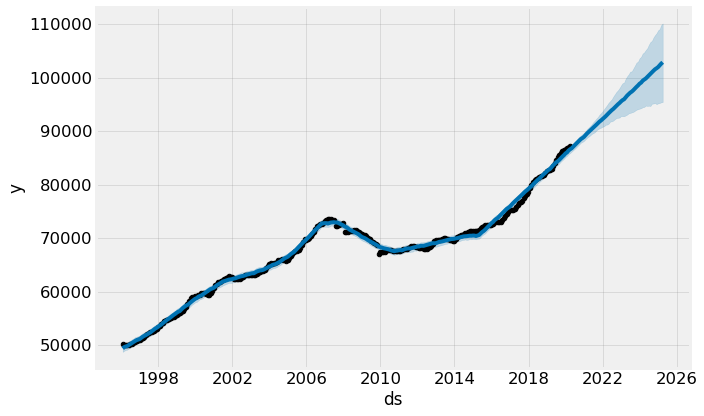

In [159]:
m = Prophet()
m.fit(Jonesboro)
future = m.make_future_dataframe(periods=60, freq='M')
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
fig1 = m.plot(forecast)

In [160]:
forecast = forecast.drop(columns=['ds'])
test = forecast.T
test['total_growth'] = (test[350]-test[290])
test['perc_growth'] = (test[350]-test[290])/test[290]
test

,0,1,2,3,4,5,6,7,8,9,...,343,344,345,346,347,348,349,350,total_growth,perc_growth
trend,49409.275634,49568.793953,49739.313534,49904.332484,50074.852066,50239.871016,50410.390598,50580.910180,50745.929130,50916.448711,...,100997.024899,101264.666503,101541.229494,101808.871098,102085.434089,102361.997079,102611.795910,102888.358901,16290.452295,0.188116
yhat_lower,48742.897053,48946.260935,49097.923264,49158.350735,49391.648584,49506.480243,49751.699262,49900.730199,50119.927260,50294.026562,...,95144.629818,95171.363712,95255.193001,95055.542959,95202.964884,95271.811179,95391.463268,95441.036185,9525.095266,0.110865
yhat_upper,50036.225073,50256.964799,50403.656612,50473.803871,50725.609472,50858.147430,51080.063605,51250.911438,51486.447717,51579.237045,...,106886.198392,107515.665321,107963.745460,108316.717521,108863.163764,109093.411873,109817.478584,110136.617890,22884.848761,0.262285
trend_lower,49409.275634,49568.793953,49739.313534,49904.332484,50074.852066,50239.871016,50410.390598,50580.910180,50745.929130,50916.448711,...,95040.291211,95116.086652,95192.338661,95271.552744,95342.752406,95467.160169,95455.647892,95588.092155,8990.185550,0.103815
trend_upper,49409.275634,49568.793953,49739.313534,49904.332484,50074.852066,50239.871016,50410.390598,50580.910180,50745.929130,50916.448711,...,106960.136793,107391.511105,107827.497050,108247.753184,108720.667589,109231.460720,109785.482837,110251.692398,23653.785792,0.273145
additive_terms,-18.575415,58.412601,13.876238,-66.892007,-54.478842,-41.271901,-13.062597,17.520850,25.942248,29.331354,...,17.520850,25.942248,29.331354,-50.399805,-103.191773,-58.111916,-4.638084,-8.485781,-22.362018,-1.611533
additive_terms_lower,-18.575415,58.412601,13.876238,-66.892007,-54.478842,-41.271901,-13.062597,17.520850,25.942248,29.331354,...,17.520850,25.942248,29.331354,-50.399805,-103.191773,-58.111916,-4.638084,-8.485781,-22.362018,-1.611533
additive_terms_upper,-18.575415,58.412601,13.876238,-66.892007,-54.478842,-41.271901,-13.062597,17.520850,25.942248,29.331354,...,17.520850,25.942248,29.331354,-50.399805,-103.191773,-58.111916,-4.638084,-8.485781,-22.362018,-1.611533
yearly,-18.575415,58.412601,13.876238,-66.892007,-54.478842,-41.271901,-13.062597,17.520850,25.942248,29.331354,...,17.520850,25.942248,29.331354,-50.399805,-103.191773,-58.111916,-4.638084,-8.485781,-22.362018,-1.611533
yearly_lower,-18.575415,58.412601,13.876238,-66.892007,-54.478842,-41.271901,-13.062597,17.520850,25.942248,29.331354,...,17.520850,25.942248,29.331354,-50.399805,-103.191773,-58.111916,-4.638084,-8.485781,-22.362018,-1.611533


In [161]:
Searcy = Metro[Metro.Metro == 'Searcy']
Searcy 

,ds,Metro,y
699,1996-01-31,Searcy,56772.416667
1560,1996-02-29,Searcy,56666.000000
2421,1996-03-31,Searcy,56678.666667
3282,1996-04-30,Searcy,56677.500000
4143,1996-05-31,Searcy,56733.750000
...,...,...,...
246945,2019-11-30,Searcy,87297.888889
247806,2019-12-31,Searcy,86611.722222
248667,2020-01-31,Searcy,86112.388889
249528,2020-02-29,Searcy,86010.611111


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


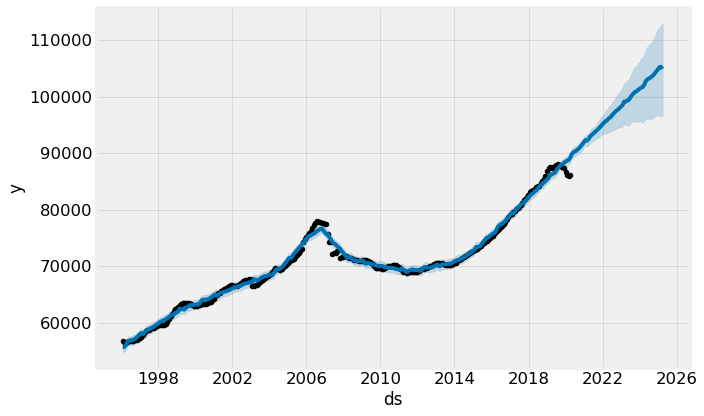

In [162]:
m = Prophet()
m.fit(Searcy)
future = m.make_future_dataframe(periods=60, freq='M')
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
fig1 = m.plot(forecast)

In [163]:
forecast = forecast.drop(columns=['ds'])
test = forecast.T
test['total_growth'] = (test[350]-test[290])
test['perc_growth'] = (test[350]-test[290])/test[290]
test

,0,1,2,3,4,5,6,7,8,9,...,343,344,345,346,347,348,349,350,total_growth,perc_growth
trend,55799.265297,55961.338718,56134.589616,56302.251775,56475.502673,56643.164832,56816.415730,56989.666628,57157.328787,57330.579685,...,103532.129457,103797.038899,104070.778656,104335.688099,104609.427856,104883.167613,105130.416426,105404.156183,16124.154729,0.180602
yhat_lower,54880.463522,54855.471022,55153.183518,55782.449409,55940.388437,56021.498341,56085.667617,56101.444804,56278.130974,56597.048197,...,96263.273045,96211.352570,96487.257962,96724.946748,96591.282955,96638.913855,96539.928175,96557.176177,8282.203457,0.093823
yhat_upper,56518.275504,56560.915853,56835.477466,57409.454352,57599.952038,57676.982815,57712.189359,57902.643590,57942.179768,58317.522135,...,109546.159313,110144.923467,110745.182864,111445.786199,111919.999152,112312.208529,112587.249968,112925.560483,22941.841405,0.254955
trend_lower,55799.265297,55961.338718,56134.589616,56302.251775,56475.502673,56643.164832,56816.415730,56989.666628,57157.328787,57330.579685,...,96258.683031,96362.219929,96382.967890,96389.592419,96476.818692,96649.020265,96645.699298,96574.548202,7294.546748,0.081704
trend_upper,55799.265297,55961.338718,56134.589616,56302.251775,56475.502673,56643.164832,56816.415730,56989.666628,57157.328787,57330.579685,...,109804.970234,110147.486056,110496.915890,111024.505189,111473.463251,111933.771669,112375.061875,112826.136795,23546.135341,0.263734
additive_terms,-71.039417,-240.606470,-132.833045,260.701661,303.800235,190.483629,79.730464,36.819961,3.446284,106.577464,...,36.819961,3.446284,106.577464,147.975835,274.688483,339.938300,-26.988346,-29.650797,103.182248,-0.776781
additive_terms_lower,-71.039417,-240.606470,-132.833045,260.701661,303.800235,190.483629,79.730464,36.819961,3.446284,106.577464,...,36.819961,3.446284,106.577464,147.975835,274.688483,339.938300,-26.988346,-29.650797,103.182248,-0.776781
additive_terms_upper,-71.039417,-240.606470,-132.833045,260.701661,303.800235,190.483629,79.730464,36.819961,3.446284,106.577464,...,36.819961,3.446284,106.577464,147.975835,274.688483,339.938300,-26.988346,-29.650797,103.182248,-0.776781
yearly,-71.039417,-240.606470,-132.833045,260.701661,303.800235,190.483629,79.730464,36.819961,3.446284,106.577464,...,36.819961,3.446284,106.577464,147.975835,274.688483,339.938300,-26.988346,-29.650797,103.182248,-0.776781
yearly_lower,-71.039417,-240.606470,-132.833045,260.701661,303.800235,190.483629,79.730464,36.819961,3.446284,106.577464,...,36.819961,3.446284,106.577464,147.975835,274.688483,339.938300,-26.988346,-29.650797,103.182248,-0.776781


In [150]:
forecast = forecast.drop(columns=['ds'])
test = forecast.T
test['total_growth'] = (test[350]-test[290])
test['perc_growth'] = (test[350]-test[290])/test[290]
test

,0,1,2,3,4,5,6,7,8,9,...,343,344,345,346,347,348,349,350,total_growth,perc_growth
trend,92924.671386,93186.163143,93465.688815,93736.197529,94015.723201,94286.231915,94565.757587,94845.283258,95115.791972,95395.317644,...,200083.814520,200720.515409,201378.439660,202015.140549,202673.064800,203330.989052,203925.243214,204583.167466,38753.860749,0.233697
yhat_lower,91994.192725,92289.302686,92691.120826,92598.367442,92898.308068,93255.576895,93619.978385,93798.453638,94092.944353,94241.488046,...,180122.616395,179382.850485,178668.824829,179690.222317,179530.579137,179323.292689,179802.483296,180004.230592,14902.091700,0.090260
yhat_upper,94032.682167,94483.232494,94772.759609,94669.747847,95011.073221,95387.377942,95657.354942,95984.676111,96048.071337,96352.471648,...,220517.732572,221546.385660,223048.351980,224105.557957,225921.000736,227264.901343,228322.206346,229676.586178,62523.563622,0.374050
trend_lower,92924.671386,93186.163143,93465.688815,93736.197529,94015.723201,94286.231915,94565.757587,94845.283258,95115.791972,95395.317644,...,179518.989979,179247.763162,179573.734257,179740.584697,179574.103438,179572.029967,179523.284477,179516.840239,13687.533523,0.082540
trend_upper,92924.671386,93186.163143,93465.688815,93736.197529,94015.723201,94286.231915,94565.757587,94845.283258,95115.791972,95395.317644,...,220620.144710,221822.984608,223252.757731,224539.463135,225733.574251,226875.184408,228015.780118,229244.650486,63415.343769,0.382413
additive_terms,96.985279,161.796459,303.002243,-138.611897,-11.072103,51.558286,38.587642,29.863715,-103.098866,-143.745214,...,29.863715,-103.098866,-143.745214,-41.649316,64.224993,273.091163,194.423106,260.383825,-42.618418,-0.140654
additive_terms_lower,96.985279,161.796459,303.002243,-138.611897,-11.072103,51.558286,38.587642,29.863715,-103.098866,-143.745214,...,29.863715,-103.098866,-143.745214,-41.649316,64.224993,273.091163,194.423106,260.383825,-42.618418,-0.140654
additive_terms_upper,96.985279,161.796459,303.002243,-138.611897,-11.072103,51.558286,38.587642,29.863715,-103.098866,-143.745214,...,29.863715,-103.098866,-143.745214,-41.649316,64.224993,273.091163,194.423106,260.383825,-42.618418,-0.140654
yearly,96.985279,161.796459,303.002243,-138.611897,-11.072103,51.558286,38.587642,29.863715,-103.098866,-143.745214,...,29.863715,-103.098866,-143.745214,-41.649316,64.224993,273.091163,194.423106,260.383825,-42.618418,-0.140654
yearly_lower,96.985279,161.796459,303.002243,-138.611897,-11.072103,51.558286,38.587642,29.863715,-103.098866,-143.745214,...,29.863715,-103.098866,-143.745214,-41.649316,64.224993,273.091163,194.423106,260.383825,-42.618418,-0.140654


In [181]:
Metro1 = data.groupby(['date', 'Metro', 'State'])['value'].mean()
Metro1 = Metro1.reset_index()
Metro1.columns = ['date', 'Metro', 'State','avg_value']
Metro1 = Metro1.rename(columns={ "date": "ds","avg_value": "y" })
Metro1

,ds,Metro,State,y
0,1996-01-31,Aberdeen,SD,NaN
1,1996-01-31,Aberdeen,WA,NaN
2,1996-01-31,Abilene,TX,NaN
3,1996-01-31,Ada,OK,33940.400000
4,1996-01-31,Adrian,MI,78817.400000
...,...,...,...,...
292741,2020-03-31,Youngstown-Warren-Boardman,PA,129729.066667
292742,2020-03-31,Yuba City,CA,350552.923077
292743,2020-03-31,Yuma,AZ,143467.800000
292744,2020-03-31,Zanesville,OH,116138.647059


# Prophet Model

In [169]:
df = pd.read_csv('Zip_Zhvi_SingleFamilyResidence.csv')

In [170]:
df = df[df['2015-03-31'].notna()]

In [171]:
#Identify top 5000 Zip codes with highest percentage growth beteeen 2015 and 2020
df['growth'] = (df['2020-03-31'] - df['2015-03-31'])/df['2015-03-31']
df = df.sort_values(by='growth', ascending=False)
df = df.head(5000)
df = df.drop(columns=['growth'])
df

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,1996-01-31,...,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31
7981,76574,8063,43205,Zip,OH,OH,Columbus,Columbus,Franklin County,65593.0,...,187702.0,190884.0,194402.0,197836.0,200347.0,202565.0,204400.0,205186.0,206203.0,207875.0
6444,71034,6502,30314,Zip,GA,GA,Atlanta,Atlanta-Sandy Springs-Roswell,Fulton County,NaN,...,155408.0,157172.0,159175.0,161203.0,163443.0,166123.0,169741.0,174383.0,180050.0,184547.0
3267,71030,3295,30310,Zip,GA,GA,Atlanta,Atlanta-Sandy Springs-Roswell,Fulton County,32361.0,...,228209.0,228698.0,229073.0,229733.0,230116.0,231321.0,232872.0,235007.0,237397.0,238612.0
2962,71862,2982,32208,Zip,FL,FL,Jacksonville,Jacksonville,Duval County,24940.0,...,99922.0,100501.0,101266.0,101774.0,102537.0,102687.0,103488.0,104364.0,105567.0,107090.0
2146,71031,2158,30311,Zip,GA,GA,Atlanta,Atlanta-Sandy Springs-Roswell,Fulton County,53180.0,...,195785.0,195887.0,196764.0,197597.0,199317.0,201088.0,203973.0,206085.0,208123.0,208673.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19683,93399,20406,80449,Zip,CO,CO,Hartsel,Denver-Aurora-Lakewood,Park County,106550.0,...,274121.0,275504.0,276864.0,277791.0,278799.0,279276.0,279547.0,279513.0,279762.0,279926.0
4681,72771,4724,33708,Zip,FL,FL,Madeira Beach,Tampa-St. Petersburg-Clearwater,Pinellas County,135424.0,...,408348.0,409005.0,409659.0,411236.0,412785.0,415012.0,416835.0,419271.0,423217.0,427676.0
27291,81278,29401,53192,Zip,WI,WI,Salem,Chicago-Naperville-Elgin,Kenosha County,109799.0,...,184752.0,185525.0,185901.0,186963.0,187608.0,187271.0,186377.0,185953.0,186753.0,187680.0
21809,93642,22858,81020,Zip,CO,CO,Aguilar,NaN,Las Animas County,NaN,...,201871.0,201939.0,201992.0,202247.0,202878.0,201318.0,199755.0,197715.0,196868.0,194371.0


### Code was leveraged from Medium article <i> Forecasting National Home Values through Time Series Analysis </i>

https://medium.com/@wvsharber/forecasting-national-home-values-through-time-series-analysis-924ac911c5a4

In [27]:
 def one_zipcode(df, index):
     """This function pulls the data for one zipcode at a time and retuns a DataFrame for using in Prophet."""
     series = df.iloc[index]
     series_data = series.iloc[9:]
     df_series = pd.DataFrame(series_data.values, index = series_data.index, columns = ['y'])
     df_series.index = pd.to_datetime(df_series.index, yearfirst = True, format = '%Y-%m')
     df_series['ds'] = df_series.index
     df_series.reset_index(drop = True, inplace = True)
     df_series['y'] = df_series['y'].astype('int64', errors='ignore')
     return df_series

In [19]:
def get_zipcode(df, index):
    """This function extracts the zipcode from the dataframe at the index. Useful in constructing data dictionanry
    later."""
    zipcode = df['RegionName'].iloc[index]
    return zipcode

In [20]:
def Prophet_analysis(df):
    """This function instantiates a Prophet model, fits it to the DataFrame, and predicts values which are returned in 
    a forecast Dataframe."""
    m = Prophet(seasonality_mode='multiplicative', interval_width=0.95)
    m.fit(df)
    future = m.make_future_dataframe(60, freq = 'M')
    forecast = m.predict(future)
    return forecast

In [21]:
def most_recent_value(df):
    '''
    Finds the most recent median home value for use in future percent calculation.
    '''
    i = -1
    while np.isnan(df.iloc[i]['y']):
        i -= 1

    return df.iloc[i]['y']

In [22]:
def combine_dataframes(df, forecast):
    """This function combines the original dataframe with data from one zipcode and the forecasted values from the
    Prophet analysis into a single DataFrame. It also adds new columns for percent change from the last value in
    the original dataframe and the estimated gross profit."""
    forecast.rename(columns={'yhat': 'y'}, inplace = True)
    forecast_subset = forecast[forecast['ds']>'2018-04-01'][['ds','y', 'yhat_lower', 'yhat_upper']]
    df_appended = df.append(forecast_subset, sort = True)
    df_appended['pct_change'] = ((df_appended['y']-most_recent_value(df))/most_recent_value(df))*100
    df_appended['gross_profit'] = (df_appended['y']-most_recent_value(df))
    return df_appended

In [36]:
def make_dict(df, zipcode):
    """This function returns a summary dictionary from the combined dataframe for a given zipcode. This dictionary
    can be appended to a list that will be used to make a final dataframe."""
    pct_change_1year = df.loc[(df['ds']>'2021-03-31') 
                                       & (df['ds']<'2021-05-01')]['pct_change'].values[0]
    gross_profit_1year = df.loc[(df['ds']>'2021-03-31') 
                                       & (df['ds']<'2021-05-01')]['gross_profit'].values[0]
    pct_change_5year = df.loc[(df['ds']>='2025-03-31')]['pct_change'].values[0]
    gross_profit_5year = df.loc[(df['ds']>='2025-03-31')]['gross_profit'].values[0]
    estimate_1year = df.loc[(df['ds']>'2021-03-31') 
                                       & (df['ds']<'2021-05-01')]['y'].values[0]
    upper_1year = df.loc[(df['ds']>'2021-03-31') 
                                       & (df['ds']<'2021-05-01')]['yhat_upper'].values[0]
    lower_1year = df.loc[(df['ds']>'2021-03-31') 
                                       & (df['ds']<'2021-05-01')]['yhat_lower'].values[0]
    estimate_5year = df.loc[(df['ds']>='2025-03-31')]['y'].values[0]
    upper_5year = df.loc[(df['ds']>='2025-03-31')]['yhat_upper'].values[0]
    lower_5year = df.loc[(df['ds']>='2025-03-31')]['yhat_lower'].values[0]
    zipcode_dict = {'Zipcode': zipcode, 
                    'estimate_1year': estimate_1year,
                    'upper_1year': upper_1year,
                    'lower_1year': lower_1year,
                    'pct_change_1year': pct_change_1year,
                    'estimate_5year': estimate_5year,
                    'upper_5year': upper_5year,
                    'lower_5year': lower_5year,
                    'gross_profit_1year': gross_profit_1year, 
                    'pct_change_5year': pct_change_5year, 
                    'gross_profit_5year': gross_profit_5year}
    return zipcode_dict

In [37]:
def prophet_master(df, start, stop):
    """Puts together all the previous functions into one function that will return a list of dictionaries with the 
    results of the prophet predictions. Can control with start/stop."""
    preds = []
    for i in range(start, stop):
        zipcode = get_zipcode(df, i)
        forecast = Prophet_analysis(one_zipcode(df, i))
        combined = combine_dataframes(one_zipcode(df, i), forecast)
        preds.append(make_dict(combined, zipcode))
    return preds

In [41]:
test = prophet_master(df, 0, 3000)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seaso

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seaso

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seaso

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seaso

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seaso

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seaso

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seaso

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seaso

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seaso

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seaso

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seaso

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seaso

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seaso

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seaso

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seaso

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seaso

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seaso

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seaso

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seaso

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seaso

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seaso

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seaso

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seaso

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seaso

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seaso

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seaso

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seaso

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seaso

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seaso

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seaso

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seaso

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seaso

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seaso

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seaso

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seaso

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seaso

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seaso

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seaso

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seaso

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seaso

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seaso

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seaso

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seaso

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seaso

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seaso

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seaso

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seaso

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seaso

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seaso

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seaso

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seaso

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seaso

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seaso

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seaso

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seaso

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seaso

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seaso

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seaso

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seaso

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seaso

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seaso

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seaso

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seaso

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seaso

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [8]:
#summary = pd.DataFrame(test)
#summary
#summary.to_csv('forecasts.csv')
summary = pd.read_csv('forecasts.csv')
summary

,Unnamed: 0,Zipcode,estimate_1year,upper_1year,lower_1year,pct_change_1year,estimate_5year,upper_5year,lower_5year,gross_profit_1year,pct_change_5year,gross_profit_5year
0,0,43205,228838.432815,242846.296184,215177.779869,10.084634,355198.578450,399286.409537,313302.647660,20963.432815,70.871234,147323.578450
1,1,30314,212936.944247,227739.577715,197258.484423,15.383585,342456.112429,506776.094401,194092.969624,28389.944247,85.565798,157909.112429
2,2,30310,283507.512139,295581.946889,270800.809516,18.815278,420717.365774,467652.163473,371848.758611,44895.512139,76.318612,182105.365774
3,3,32208,125945.156263,131206.398608,120887.435677,17.606832,185227.063078,206334.903701,161384.887227,18855.156263,72.963921,78137.063078
4,4,30311,241847.707103,251462.013682,231920.496736,15.897939,352237.009331,398298.821310,301251.637304,33174.707103,68.798555,143564.009331
...,...,...,...,...,...,...,...,...,...,...,...,...
2995,2995,98829,163544.571649,170050.217895,157441.768228,5.660552,188453.314198,242417.157506,136076.663416,8761.571649,21.753238,33670.314198
2996,2996,95334,283475.385556,293420.877761,272305.114728,3.188148,325352.600377,411996.607838,223834.274279,8758.385556,18.431914,50635.600377
2997,2997,74423,78572.958991,80227.092271,76612.208545,3.966866,94898.801120,107363.725146,83732.501758,2997.958991,25.569039,19323.801120
2998,2998,85020,348188.542941,374953.182682,327742.794502,7.942345,425811.609155,646259.468299,210355.878542,25619.542941,32.006364,103242.609155


In [173]:
df = df.rename(columns={'RegionName': 'Zipcode'})

In [20]:
merge=df.merge(summary, left_on='Zipcode',right_on='Zipcode')
merge

,RegionID,SizeRank,Zipcode,RegionType,StateName,State,City,Metro,CountyName,1996-01-31,...,estimate_1year,upper_1year,lower_1year,pct_change_1year,estimate_5year,upper_5year,lower_5year,gross_profit_1year,pct_change_5year,gross_profit_5year
0,76574,8063,43205,Zip,OH,OH,Columbus,Columbus,Franklin County,65593.0,...,228838.432815,242846.296184,215177.779869,10.084634,355198.578450,399286.409537,313302.647660,20963.432815,70.871234,147323.578450
1,71034,6502,30314,Zip,GA,GA,Atlanta,Atlanta-Sandy Springs-Roswell,Fulton County,NaN,...,212936.944247,227739.577715,197258.484423,15.383585,342456.112429,506776.094401,194092.969624,28389.944247,85.565798,157909.112429
2,71030,3295,30310,Zip,GA,GA,Atlanta,Atlanta-Sandy Springs-Roswell,Fulton County,32361.0,...,283507.512139,295581.946889,270800.809516,18.815278,420717.365774,467652.163473,371848.758611,44895.512139,76.318612,182105.365774
3,71862,2982,32208,Zip,FL,FL,Jacksonville,Jacksonville,Duval County,24940.0,...,125945.156263,131206.398608,120887.435677,17.606832,185227.063078,206334.903701,161384.887227,18855.156263,72.963921,78137.063078
4,71031,2158,30311,Zip,GA,GA,Atlanta,Atlanta-Sandy Springs-Roswell,Fulton County,53180.0,...,241847.707103,251462.013682,231920.496736,15.897939,352237.009331,398298.821310,301251.637304,33174.707103,68.798555,143564.009331
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,99985,25703,98829,Zip,WA,WA,Okanogan,NaN,Okanogan County,NaN,...,163544.571649,170050.217895,157441.768228,5.660552,188453.314198,242417.157506,136076.663416,8761.571649,21.753238,33670.314198
2996,98116,9292,95334,Zip,CA,CA,Livingston,Merced,Merced County,NaN,...,283475.385556,293420.877761,272305.114728,3.188148,325352.600377,411996.607838,223834.274279,8758.385556,18.431914,50635.600377
2997,90387,23614,74423,Zip,OK,OK,Braggs,Muskogee,Muskogee County,30401.0,...,78572.958991,80227.092271,76612.208545,3.966866,94898.801120,107363.725146,83732.501758,2997.958991,25.569039,19323.801120
2998,94736,1453,85020,Zip,AZ,AZ,Phoenix,Phoenix-Mesa-Scottsdale,Maricopa County,112390.0,...,348188.542941,374953.182682,327742.794502,7.942345,425811.609155,646259.468299,210355.878542,25619.542941,32.006364,103242.609155


In [21]:
merge['gross_5'] = merge['estimate_5year']-merge['2020-03-31']
merge['upper_5'] = merge['upper_5year']-merge['2020-03-31']
merge['lower_5'] = merge['lower_5year']-merge['2020-03-31']
merge

,RegionID,SizeRank,Zipcode,RegionType,StateName,State,City,Metro,CountyName,1996-01-31,...,pct_change_1year,estimate_5year,upper_5year,lower_5year,gross_profit_1year,pct_change_5year,gross_profit_5year,gross_5,upper_5,lower_5
0,76574,8063,43205,Zip,OH,OH,Columbus,Columbus,Franklin County,65593.0,...,10.084634,355198.578450,399286.409537,313302.647660,20963.432815,70.871234,147323.578450,147323.578450,191411.409537,105427.647660
1,71034,6502,30314,Zip,GA,GA,Atlanta,Atlanta-Sandy Springs-Roswell,Fulton County,NaN,...,15.383585,342456.112429,506776.094401,194092.969624,28389.944247,85.565798,157909.112429,157909.112429,322229.094401,9545.969624
2,71030,3295,30310,Zip,GA,GA,Atlanta,Atlanta-Sandy Springs-Roswell,Fulton County,32361.0,...,18.815278,420717.365774,467652.163473,371848.758611,44895.512139,76.318612,182105.365774,182105.365774,229040.163473,133236.758611
3,71862,2982,32208,Zip,FL,FL,Jacksonville,Jacksonville,Duval County,24940.0,...,17.606832,185227.063078,206334.903701,161384.887227,18855.156263,72.963921,78137.063078,78137.063078,99244.903701,54294.887227
4,71031,2158,30311,Zip,GA,GA,Atlanta,Atlanta-Sandy Springs-Roswell,Fulton County,53180.0,...,15.897939,352237.009331,398298.821310,301251.637304,33174.707103,68.798555,143564.009331,143564.009331,189625.821310,92578.637304
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,99985,25703,98829,Zip,WA,WA,Okanogan,NaN,Okanogan County,NaN,...,5.660552,188453.314198,242417.157506,136076.663416,8761.571649,21.753238,33670.314198,33670.314198,87634.157506,-18706.336584
2996,98116,9292,95334,Zip,CA,CA,Livingston,Merced,Merced County,NaN,...,3.188148,325352.600377,411996.607838,223834.274279,8758.385556,18.431914,50635.600377,50635.600377,137279.607838,-50882.725721
2997,90387,23614,74423,Zip,OK,OK,Braggs,Muskogee,Muskogee County,30401.0,...,3.966866,94898.801120,107363.725146,83732.501758,2997.958991,25.569039,19323.801120,19323.801120,31788.725146,8157.501758
2998,94736,1453,85020,Zip,AZ,AZ,Phoenix,Phoenix-Mesa-Scottsdale,Maricopa County,112390.0,...,7.942345,425811.609155,646259.468299,210355.878542,25619.542941,32.006364,103242.609155,103242.609155,323690.468299,-112213.121458


In [93]:
merge.sort_values(by='gross_5', ascending=False).head(5)

,RegionID,SizeRank,Zipcode,RegionType,StateName,State,City,Metro,CountyName,1996-01-31,...,pct_change_1year,estimate_5year,upper_5year,lower_5year,gross_profit_1year,pct_change_5year,gross_profit_5year,gross_5,upper_5,lower_5
180,96086,5355,90210,Zip,CA,CA,Beverly Hills,Los Angeles-Long Beach-Anaheim,Los Angeles County,601772.0,...,8.669186,8.465478e+06,9.409618e+06,7.553520e+06,511710.923701,43.418486,2.562837e+06,2.562837e+06,3.506977e+06,1.650879e+06
1242,97518,12494,94027,Zip,CA,CA,Atherton,San Francisco-Oakland-Hayward,San Mateo County,761550.0,...,7.441963,9.028925e+06,1.022980e+07,8.018039e+06,495743.373635,35.539736,2.367465e+06,2.367465e+06,3.568337e+06,1.356579e+06
47,96001,1092,90020,Zip,CA,CA,Los Angeles,Los Angeles-Long Beach-Anaheim,Los Angeles County,279971.0,...,9.945254,6.113315e+06,6.775746e+06,5.413689e+06,399185.869201,52.306153,2.099482e+06,2.099482e+06,2.761913e+06,1.399856e+06
210,96149,8431,90402,Zip,CA,CA,Santa Monica,Los Angeles-Long Beach-Anaheim,Los Angeles County,518302.0,...,9.158814,6.410941e+06,7.327795e+06,5.389391e+06,407497.696707,44.090675,1.961700e+06,1.961700e+06,2.878554e+06,9.401505e+05
54,96088,7464,90212,Zip,CA,CA,Beverly Hills,Los Angeles-Long Beach-Anaheim,Los Angeles County,298347.0,...,9.295454,4.981539e+06,5.616099e+06,4.267032e+06,309078.961667,49.818238,1.656484e+06,1.656484e+06,2.291044e+06,9.419771e+05


In [97]:
No_Ca = merge[merge.StateName != 'CA']
No_Ca.sort_values(by='gross_5', ascending=False).head(5)

,RegionID,SizeRank,Zipcode,RegionType,StateName,State,City,Metro,CountyName,1996-01-31,...,pct_change_1year,estimate_5year,upper_5year,lower_5year,gross_profit_1year,pct_change_5year,gross_profit_5year,gross_5,upper_5,lower_5
2411,99524,15340,98039,Zip,WA,WA,Medina,Seattle-Tacoma-Bellevue,King County,586252.0,...,14.463320,4.257732e+06,4.923794e+06,3.615972e+06,433789.233907,41.960495,1.258495e+06,1.258495e+06,1.924557e+06,616734.674170
1525,99492,1075,98004,Zip,WA,WA,Bellevue,Seattle-Tacoma-Bellevue,King County,456772.0,...,14.241210,3.174695e+06,3.669012e+06,2.606067e+06,316761.100048,42.730565,9.504376e+05,9.504376e+05,1.444755e+06,381809.944184
2865,99525,4474,98040,Zip,WA,WA,Mercer Island,Seattle-Tacoma-Bellevue,King County,474753.0,...,14.265736,2.443920e+06,2.803980e+06,2.011373e+06,248701.429126,40.185443,7.005721e+05,7.005721e+05,1.060632e+06,268024.585674
1940,99493,5957,98005,Zip,WA,WA,Bellevue,Seattle-Tacoma-Bellevue,King County,316234.0,...,18.027929,1.999065e+06,2.336418e+06,1.646629e+06,244124.124296,47.625765,6.449214e+05,6.449214e+05,9.822742e+05,292484.560334
873,84147,15927,59716,Zip,MT,MT,Gallatin Gateway,Bozeman,Gallatin County,NaN,...,10.210725,1.931991e+06,2.270781e+06,1.600950e+06,134001.982800,47.214440,6.196258e+05,6.196258e+05,9.584162e+05,288584.634438


In [23]:
merge.sort_values(by='upper_5', ascending=False).head(5)

,RegionID,SizeRank,Zipcode,RegionType,StateName,State,City,Metro,CountyName,1996-01-31,...,pct_change_1year,estimate_5year,upper_5year,lower_5year,gross_profit_1year,pct_change_5year,gross_profit_5year,gross_5,upper_5,lower_5
1242,97518,12494,94027,Zip,CA,CA,Atherton,San Francisco-Oakland-Hayward,San Mateo County,761550.0,...,7.441963,9.028925e+06,1.022980e+07,8.018039e+06,495743.373635,35.539736,2.367465e+06,2.367465e+06,3.568337e+06,1.356579e+06
180,96086,5355,90210,Zip,CA,CA,Beverly Hills,Los Angeles-Long Beach-Anaheim,Los Angeles County,601772.0,...,8.669186,8.465478e+06,9.409618e+06,7.553520e+06,511710.923701,43.418486,2.562837e+06,2.562837e+06,3.506977e+06,1.650879e+06
210,96149,8431,90402,Zip,CA,CA,Santa Monica,Los Angeles-Long Beach-Anaheim,Los Angeles County,518302.0,...,9.158814,6.410941e+06,7.327795e+06,5.389391e+06,407497.696707,44.090675,1.961700e+06,1.961700e+06,2.878554e+06,9.401505e+05
47,96001,1092,90020,Zip,CA,CA,Los Angeles,Los Angeles-Long Beach-Anaheim,Los Angeles County,279971.0,...,9.945254,6.113315e+06,6.775746e+06,5.413689e+06,399185.869201,52.306153,2.099482e+06,2.099482e+06,2.761913e+06,1.399856e+06
2637,96957,7196,92625,Zip,CA,CA,Newport Beach,Los Angeles-Long Beach-Anaheim,Orange County,536824.0,...,8.162667,4.323285e+06,5.609702e+06,2.959489e+06,266091.442648,32.621851,1.063426e+06,1.063426e+06,2.349843e+06,-3.003697e+05


In [24]:
merge.sort_values(by='lower_5', ascending=False).head(5)

,RegionID,SizeRank,Zipcode,RegionType,StateName,State,City,Metro,CountyName,1996-01-31,...,pct_change_1year,estimate_5year,upper_5year,lower_5year,gross_profit_1year,pct_change_5year,gross_profit_5year,gross_5,upper_5,lower_5
180,96086,5355,90210,Zip,CA,CA,Beverly Hills,Los Angeles-Long Beach-Anaheim,Los Angeles County,601772.0,...,8.669186,8.465478e+06,9.409618e+06,7.553520e+06,511710.923701,43.418486,2.562837e+06,2.562837e+06,3.506977e+06,1.650879e+06
47,96001,1092,90020,Zip,CA,CA,Los Angeles,Los Angeles-Long Beach-Anaheim,Los Angeles County,279971.0,...,9.945254,6.113315e+06,6.775746e+06,5.413689e+06,399185.869201,52.306153,2.099482e+06,2.099482e+06,2.761913e+06,1.399856e+06
1242,97518,12494,94027,Zip,CA,CA,Atherton,San Francisco-Oakland-Hayward,San Mateo County,761550.0,...,7.441963,9.028925e+06,1.022980e+07,8.018039e+06,495743.373635,35.539736,2.367465e+06,2.367465e+06,3.568337e+06,1.356579e+06
26,96150,2342,90403,Zip,CA,CA,Santa Monica,Los Angeles-Long Beach-Anaheim,Los Angeles County,166921.0,...,12.876434,4.078584e+06,4.463067e+06,3.684127e+06,338470.468701,55.161604,1.449980e+06,1.449980e+06,1.834463e+06,1.055523e+06
87,96050,2118,90069,Zip,CA,CA,West Hollywood,Los Angeles-Long Beach-Anaheim,Los Angeles County,257517.0,...,11.179561,4.476771e+06,4.917660e+06,4.027336e+06,332987.123743,50.301116,1.498236e+06,1.498236e+06,1.939125e+06,1.048801e+06


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


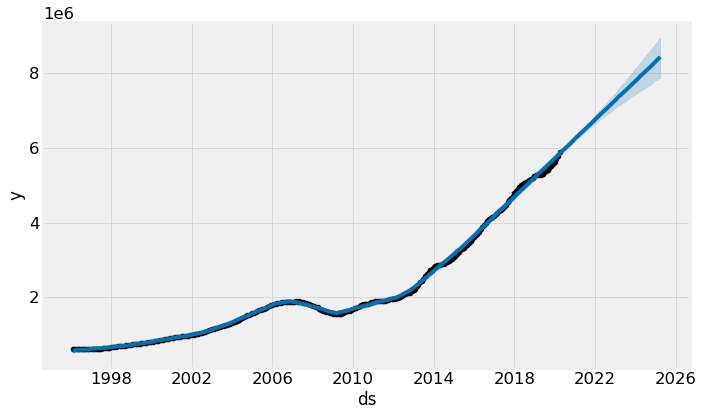

In [174]:
region_row = df[df['Zipcode'] == 90210]
r_df = pd.DataFrame({ 'y': region_row.loc[:, "1996-01-31"::].values[0], 'ds': ds })
m = Prophet()
m.fit(r_df)
future = m.make_future_dataframe(periods=60, freq='M')
forecast = m.predict(future)
fig1 = m.plot(forecast)

In [121]:
forecast = forecast.drop(columns=['ds'])
test = forecast.T
test['total_growth'] = (test[350]-test[290])
test['perc_growth'] = (test[350]-test[290])/test[290]
test

,0,1,2,3,4,5,6,7,8,9,...,343,344,345,346,347,348,349,350,total_growth,perc_growth
trend,571322.492400,574729.486777,578371.446285,581895.923227,585537.882735,589062.359677,592704.319185,596346.278692,599870.755635,603512.715142,...,8.127703e+06,8.170173e+06,8.214058e+06,8.256527e+06,8.300413e+06,8.344298e+06,8.383936e+06,8.427821e+06,2.584983e+06,0.442419
yhat_lower,519672.245555,519323.582414,532104.704240,534556.346727,535122.998683,535042.454456,537428.616603,532853.482496,542126.978664,546523.932079,...,7.684830e+06,7.724730e+06,7.758362e+06,7.799463e+06,7.831340e+06,7.858052e+06,7.877270e+06,7.905205e+06,2.110524e+06,0.364217
yhat_upper,632554.482396,627873.279630,641992.738605,643051.440585,647130.792852,647192.789184,650352.458939,646387.570830,650279.052236,660608.166917,...,8.584775e+06,8.655095e+06,8.701984e+06,8.748872e+06,8.817495e+06,8.897900e+06,8.930899e+06,8.991311e+06,3.083787e+06,0.522010
trend_lower,571322.492400,574729.486777,578371.446285,581895.923227,585537.882735,589062.359677,592704.319185,596346.278692,599870.755635,603512.715142,...,7.703590e+06,7.728142e+06,7.760496e+06,7.788864e+06,7.821506e+06,7.844991e+06,7.869410e+06,7.901762e+06,2.058924e+06,0.352384
trend_upper,571322.492400,574729.486777,578371.446285,581895.923227,585537.882735,589062.359677,592704.319185,596346.278692,599870.755635,603512.715142,...,8.593345e+06,8.648343e+06,8.710068e+06,8.762349e+06,8.819163e+06,8.873884e+06,8.921508e+06,8.976675e+06,3.133837e+06,0.536355
additive_terms,233.014446,-540.376897,9098.479036,5320.049532,4382.021707,3949.198177,1193.905247,-2705.687017,-3160.125685,-2516.677878,...,-2.705687e+03,-3.160126e+03,-2.516678e+03,1.901658e+03,6.228655e+03,9.504917e+03,5.158495e+03,8.790828e+03,-3.076509e+02,-0.033813
additive_terms_lower,233.014446,-540.376897,9098.479036,5320.049532,4382.021707,3949.198177,1193.905247,-2705.687017,-3160.125685,-2516.677878,...,-2.705687e+03,-3.160126e+03,-2.516678e+03,1.901658e+03,6.228655e+03,9.504917e+03,5.158495e+03,8.790828e+03,-3.076509e+02,-0.033813
additive_terms_upper,233.014446,-540.376897,9098.479036,5320.049532,4382.021707,3949.198177,1193.905247,-2705.687017,-3160.125685,-2516.677878,...,-2.705687e+03,-3.160126e+03,-2.516678e+03,1.901658e+03,6.228655e+03,9.504917e+03,5.158495e+03,8.790828e+03,-3.076509e+02,-0.033813
yearly,233.014446,-540.376897,9098.479036,5320.049532,4382.021707,3949.198177,1193.905247,-2705.687017,-3160.125685,-2516.677878,...,-2.705687e+03,-3.160126e+03,-2.516678e+03,1.901658e+03,6.228655e+03,9.504917e+03,5.158495e+03,8.790828e+03,-3.076509e+02,-0.033813
yearly_lower,233.014446,-540.376897,9098.479036,5320.049532,4382.021707,3949.198177,1193.905247,-2705.687017,-3160.125685,-2516.677878,...,-2.705687e+03,-3.160126e+03,-2.516678e+03,1.901658e+03,6.228655e+03,9.504917e+03,5.158495e+03,8.790828e+03,-3.076509e+02,-0.033813


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


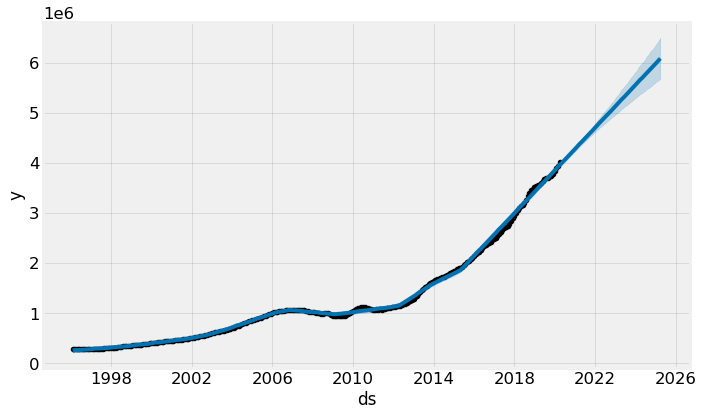

In [175]:
region_row = df[df['Zipcode'] == 90020]
r_df = pd.DataFrame({ 'y': region_row.loc[:, "1996-01-31"::].values[0], 'ds': ds })
m = Prophet()
m.fit(r_df)
future = m.make_future_dataframe(periods=60, freq='M')
forecast = m.predict(future)
fig1 = m.plot(forecast)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


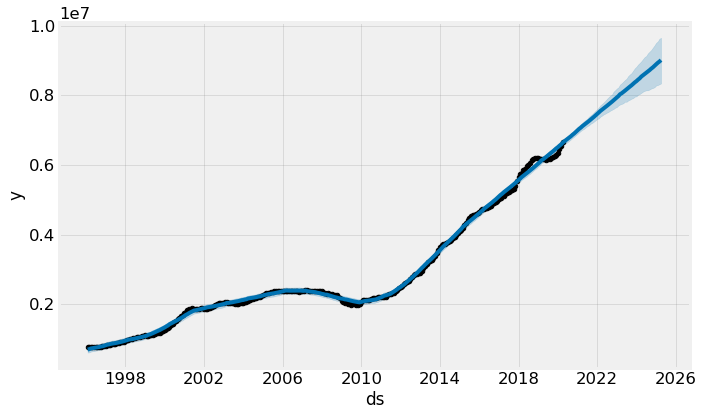

In [176]:
region_row = df[df['Zipcode'] == 94027]
r_df = pd.DataFrame({ 'y': region_row.loc[:, "1996-01-31"::].values[0], 'ds': ds })
m = Prophet()
m.fit(r_df)
future = m.make_future_dataframe(periods=60, freq='M')
forecast = m.predict(future)
fig1 = m.plot(forecast)

In [32]:
merge.sort_values(by='pct_change_5year', ascending=False).head(5)

,RegionID,SizeRank,Zipcode,RegionType,StateName,State,City,Metro,CountyName,1996-01-31,...,pct_change_1year,estimate_5year,upper_5year,lower_5year,gross_profit_1year,pct_change_5year,gross_profit_5year,gross_5,upper_5,lower_5
37,79093,4341,48238,Zip,MI,MI,Detroit,Detroit-Warren-Dearborn,Wayne County,NaN,...,35.392302,53079.480132,62556.962210,43317.297062,9282.692874,102.377155,26851.480132,26851.480132,36328.962210,17089.297062
2960,68489,29849,25160,Zip,WV,WV,Pond Gap,Charleston,Clay County,NaN,...,27.605633,104615.962022,142091.740641,63692.893298,14381.706629,100.809955,52518.962022,52518.962022,89994.740641,11595.893298
486,76119,29560,41743,Zip,KY,KY,Ary,NaN,Perry County,NaN,...,21.928934,82114.012276,100536.774227,63460.717742,9172.873165,96.304117,40284.012276,40284.012276,58706.774227,21630.717742
72,90799,28571,75247,Zip,TX,TX,Dallas,Dallas-Fort Worth-Arlington,Dallas County,NaN,...,33.248817,282979.893645,306348.445630,259767.119591,50624.315650,85.854297,130720.893645,130720.893645,154089.445630,107508.119591
1,71034,6502,30314,Zip,GA,GA,Atlanta,Atlanta-Sandy Springs-Roswell,Fulton County,NaN,...,15.383585,342456.112429,506776.094401,194092.969624,28389.944247,85.565798,157909.112429,157909.112429,322229.094401,9545.969624


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


AttributeError: 'Figure' object has no attribute 'title'

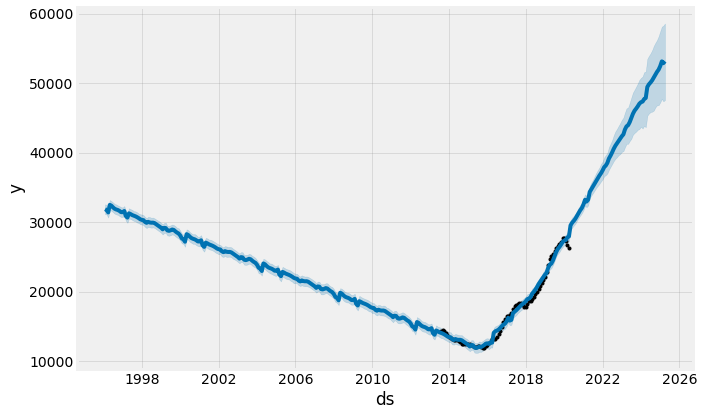

In [46]:
region_row = df[df['Zipcode'] == 48238]
r_df = pd.DataFrame({ 'y': region_row.loc[:, "1996-01-31"::].values[0], 'ds': ds })
m = Prophet()
m.fit(r_df)
future = m.make_future_dataframe(periods=60, freq='M')
forecast = m.predict(future)
fig1 = m.plot(forecast)
fig1.title('48238')
fig1.show()

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


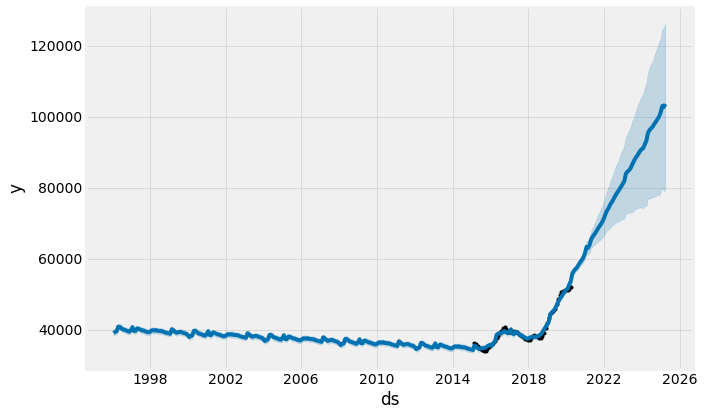

In [34]:
region_row = df[df['Zipcode'] == 25160]
r_df = pd.DataFrame({ 'y': region_row.loc[:, "1996-01-31"::].values[0], 'ds': ds })
m = Prophet()
m.fit(r_df)
future = m.make_future_dataframe(periods=60, freq='M')
forecast = m.predict(future)
fig1 = m.plot(forecast)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


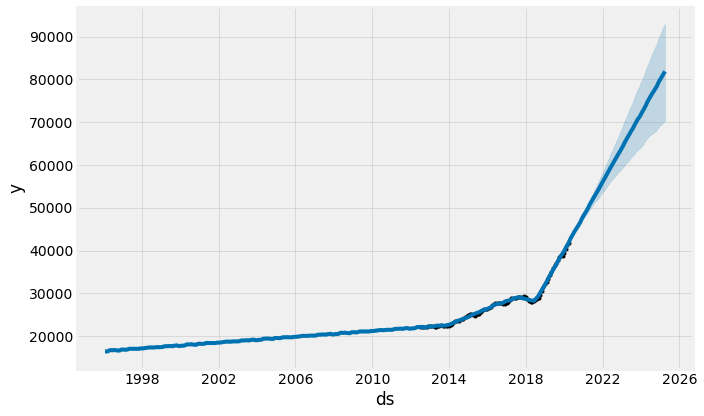

In [35]:
region_row = df[df['Zipcode'] == 41743]
r_df = pd.DataFrame({ 'y': region_row.loc[:, "1996-01-31"::].values[0], 'ds': ds })
m = Prophet()
m.fit(r_df)
future = m.make_future_dataframe(periods=60, freq='M')
forecast = m.predict(future)
fig1 = m.plot(forecast)